## Importing headers

In [84]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Data Loading and Exploration

In [86]:
ticker = "AAPL"
df = yf.download(ticker, start="2020-01-01")
df

C:\Users\rk\AppData\Local\Temp\ipykernel_19524\101187372.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620842,72.681289,71.373218,71.627092,135480400
2020-01-03,71.914810,72.676439,71.689950,71.847110,146322800
2020-01-06,72.487854,72.526541,70.783256,71.034717,118387200
2020-01-07,72.146950,72.753831,71.926922,72.497537,108872000
2020-01-08,73.307503,73.609737,71.849525,71.849525,132079200
...,...,...,...,...,...
2025-07-29,211.270004,214.809998,210.820007,214.179993,51411700
2025-07-30,209.050003,212.389999,207.720001,211.899994,45512500


<Axes: xlabel='Date'>

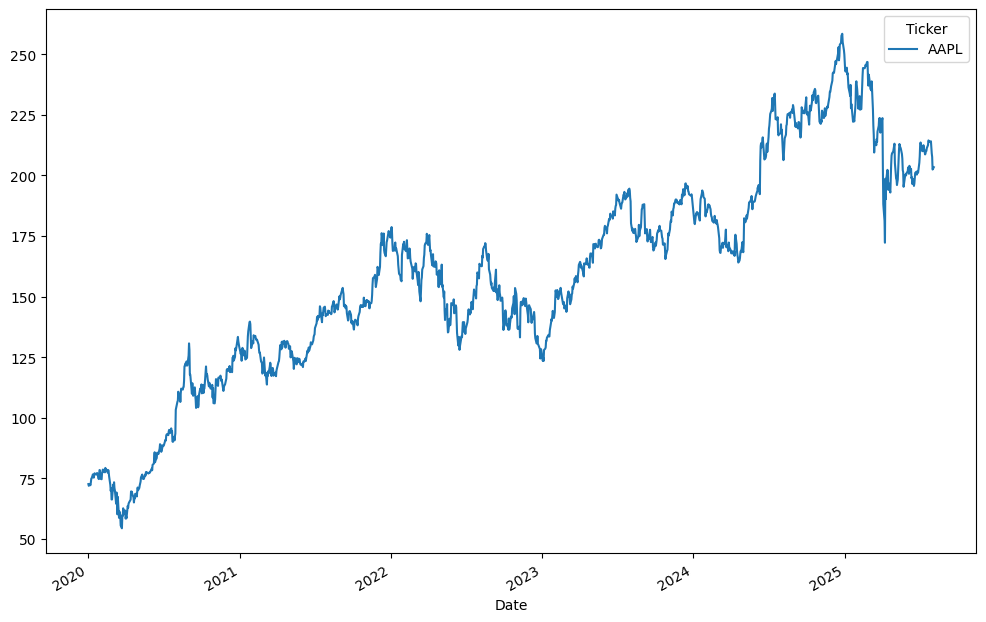

In [87]:
df.Close.plot(figsize=(12,8))

In [88]:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

In [89]:
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.930650
2020-01-03,-1.946509
2020-01-06,-1.933637
2020-01-07,-1.941294
2020-01-08,-1.915225
...,...
2025-07-29,1.183796
2025-07-30,1.133929
2025-07-31,1.100684


In [90]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])    # Each sequence overlaps with the previous one by 29 elements.

data = np.array(data)

There is overlap. That is if input is 1,2 then test is 3, the next set will be input --> 2,3 and pred --> 4  
  

![](./image.png)  
  
  The arrow shows pred value

In [91]:
data

array([[[-1.93064952],
        [-1.94650896],
        [-1.9336368 ],
        ...,
        [-1.82192461],
        [-1.7806038 ],
        [-1.79328881]],

       [[-1.94650896],
        [-1.9336368 ],
        [-1.94129446],
        ...,
        [-1.7806038 ],
        [-1.79328881],
        [-1.792853  ]],

       [[-1.9336368 ],
        [-1.94129446],
        [-1.91522521],
        ...,
        [-1.79328881],
        [-1.792853  ],
        [-1.82524556]],

       ...,

       [[ 0.83270275],
        [ 0.85381782],
        [ 0.95310326],
        ...,
        [ 1.24624261],
        [ 1.18379611],
        [ 1.13392871]],

       [[ 0.85381782],
        [ 0.95310326],
        [ 0.96433465],
        ...,
        [ 1.18379611],
        [ 1.13392871],
        [ 1.10068389]],

       [[ 0.95310326],
        [ 0.96433465],
        [ 0.93737938],
        ...,
        [ 1.13392871],
        [ 1.10068389],
        [ 0.98410201]]])

In [92]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device) # first 29 elements in all sequences
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)  # last element ie 30th element

X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)  # only diff is no :train_size but starts from train_size:
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

#### Why We Don't Shuffle Time Series Data

Unlike regular machine learning tasks (e.g., classification with `train_test_split(shuffle=True)`), time series data has a **temporal order**.

Shuffling the data would break the sequence of events and **leak future information into the past**, making the model unrealistic and invalid for real-world prediction.

So we keep the **older data for training** and the **newer data for testing**, preserving the timeline and making the prediction task reflect real scenarios.


___________________

## Model

In [93]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [94]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [95]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [96]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model (X_train)

    loss = criterion(y_train_pred, y_train)

    if i == 0 or (i + 1) % 25 == 0:
        print(i+1, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

1 0.7044833898544312
25 0.009206242859363556
50 0.005937922280281782
75 0.005247144959867001
100 0.004921857733279467
125 0.004632361698895693
150 0.0043573579750955105
175 0.004097179509699345
200 0.0038704026956111193


In [97]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [98]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
print(f"Train RMSE: {train_rmse}")

test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])
print(f"Test RMSE: {test_rmse}")

Train RMSE: 2.7695841789245605
Test RMSE: 6.024062633514404
